In [1]:
import sys
import numpy as np
from pylab import *
from numpy.linalg import det,inv
from scipy.optimize import minimize, fmin_l_bfgs_b

## パラメータ

In [2]:
# plot parameters
N    = 100
xmin = -1
xmax = 3.5
ymin = -1
ymax = 3

## データ＆初期パラメータ

In [3]:
train = np.array([ [-0.5,	0.7], [0.5,	1.8], [1,1.7], [1.4,	2.3], [3,1],[2.3,0],[2.5,0.2],[1.5,2],[1.1,2.4],[0.7,	1.5]])

# kernel parameters
tau = log(1.0)
sigma = log(1.0)
eta   = log(1.0)

In [4]:
xtrain = train.T[0]
ytrain = train.T[1]

### カーネル

In [5]:
#eq. 3.96
def gauss (params, xi, xj):
    [tau, sigma, eta] = params
    
    if xi == xj:
      a = 1
    else:
      a = 0
    return exp(tau) * exp (-(xi - xj)**2 / exp(sigma)) + (exp(eta)*a)

### 偏微分

In [6]:
#eq. 3.96以降
def gauss_grad (xi,xj,d,kernel,params):
    [tau, sigma, eta] = params
    
    if xi == xj:
      a = 1
    else:
      a=0
    
    if d == 0: #tau
        return np.exp(tau) * np.exp (-(xi - xj)**2 / np.exp(sigma)) 
        #return -exp(params[d]) + kernel(params, xi, xj)
      
    if d == 1: #sigma
        #return (np.exp(tau) * np.exp (-(xi - xj)**2 / np.exp(sigma))) * (xi - xj) * (xi - xj) / np.exp(params[d])
        return (kernel(params, xi, xj) - np.exp(eta) * a) * np.exp(-params[d]) * np.square(xi - xj)
    
    if d == 2: #eta
        return (np.exp(params[d]) if xi == xj else 0)
    else:
        return 0
 

### カーネル行列計算

In [7]:
def kernel_matrix_calc (xx, kernel, params):
    N = len(xx)
    return np.array ([kernel(params, xi, xj) for xi in xx for xj in xx]).reshape(N,N)

In [8]:
#パラメータの推移をみる関数(あってもなくても)
def printparam (params):
    print (params)

In [9]:
##eq. 3.92
#目的関数
def loglik (params,xtrain,ytrain,kernel,k_grad):
    K = kernel_matrix_calc (xtrain, kernel,params)
    Kinv = np.linalg.inv(K)
    return np.log(np.linalg.det(K)) + ytrain.T.dot(Kinv).dot(ytrain)

In [10]:
#勾配計算
##準備
def tr(A,B):
    return (A*B.T).sum()

##eq. 3.95
def gradient (params,xtrain,ytrain,kernel,k_grad):
    K = kernel_matrix_calc (xtrain, kernel,params)
    Kinv = np.linalg.inv(K)
    Kinvy = np.dot(Kinv, ytrain)
    D = len(params)
    N = len(xtrain)
    grad = np.zeros(D)
    
    for d in range(D):
        G = np.array ([k_grad (xi, xj, d, kernel, params) for xi in xtrain for xj in xtrain]).reshape(N,N)
        grad[d] = tr(Kinv,G) - Kinvy.dot(G).dot(Kinvy)
    return grad

## 最適化

In [11]:
def optimize (xtrain, ytrain, kernel, k_grad, params):
    #目的関数, 初期値, 目的関数に渡す引数, 勾配, 最適化手法, コールバック, オプション(勾配の終了目標, 結果の表示)
    res = minimize (loglik, params, args = (xtrain,ytrain,kernel,k_grad), jac = gradient, method = 'BFGS', callback = printparam, options = {'gtol' : 1e-4, 'disp' : True})
    
    print ("message: ",res.message)
    return res.x #params

In [12]:
def optimize1 (xtrain, ytrain, kernel, k_grad, params):
    x,f,d = fmin_l_bfgs_b (loglik, params, fprime=gradient, args=[xtrain,ytrain,kernel,k_grad], iprint=0, maxiter=1000)
    print (d)
    return x

In [13]:
kernel = gauss
k_grad  = gauss_grad
params = np.array ([tau, sigma, eta])

#最適化方法変更
params = optimize (xtrain, ytrain, kernel, k_grad, params)
#params = optimize1 (xtrain, ytrain, kernel, k_grad, params)

[ 0.11603271  0.16783012 -0.98917615]
[ 1.0579929  -0.7707608  -3.05517786]
[ 0.33332363 -0.35210078 -3.36309876]
[ 0.23621252 -0.40332506 -2.9155413 ]
[ 0.40777313 -0.27429429 -2.76280004]
[ 0.47758735 -0.42365266 -2.76627534]
[ 0.42252988 -0.37400435 -2.70015824]
[ 0.42161247 -0.3721224  -2.70262992]
[ 0.42166594 -0.37209994 -2.70286591]
Optimization terminated successfully.
         Current function value: 2.509299
         Iterations: 9
         Function evaluations: 11
         Gradient evaluations: 11
message:  Optimization terminated successfully.


## 予測

### code3-4参照

In [14]:
#gauss = kernel　なので
#k = kernel(params, x, x)

In [15]:
#Kの算出
K = []
N = len(ytrain)

for n in range(N):
  for n_d in range(N):
    k = kernel(params, xtrain[n],xtrain[n_d])
    K.append(k)
K = np.array(K).reshape(N,N)

In [16]:
#K_inv, yyの算出
K_inv = np.linalg.inv(K)
yy = np.dot(K_inv, ytrain)

In [17]:
#xtest作成
xx = np.linspace(xmin, xmax, 200)

In [18]:
#MuとSigmaの作成
M = len(xx)
Mu = []
Sigma = []
for m in range(M):
  k = []
  for n in range(N):
    k_ = kernel(params, xtrain[n], xx[m])
    k.append(k_)
  
  k = np.array(k)  
  #s = gauss(xx[m], xx[m], theta1, theta2)
  s = kernel(params, xx[m], xx[m])
  mu = np.dot(k, yy)
  sigma = s - k.T.dot(K_inv).dot(k)
  Mu.append(mu)
  Sigma.append(sigma)

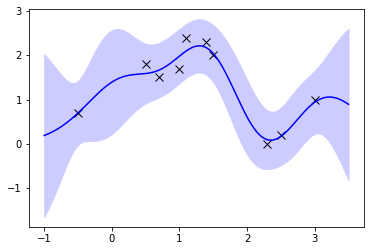

In [19]:
plt.figure()
plot (xtrain, ytrain, 'kx', markersize=8)
plot (xx, Mu, 'b-')
fill_between (xx, Mu - 2*sqrt(Sigma), Mu + 2*sqrt(Sigma), color='#ccccff')
show ()